# BERT NLP

BERT—short for Bidirectional Encoder Representations from Transformers—was unveiled by Google in 2018 as a truly transformative language model.
BERT has two applications:
1. Predicting a missing word(masked word) from a sentence.
2. It is used for Question-Answer reasoning wherein the output answer is selected as a span of the context provided.

We will try out both capabilities of the model.

## 1. Tokenisation

In [ ]:
import torch
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertModel, BertForMaskedLM, BertForQuestionAnswering

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [4]:
#Creating bert tokeniser
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
tokenizer.vocab_size

28996

In [5]:
#Sample texts
text_1 = "I am good at both chess and boxing"
text_2 = "What am I good at?"

In [6]:
# Tokenization with special tokens: [CLS] at beginning and [SEP] at end
indexed_tokens = tokenizer.encode(text_1, text_2, add_special_tokens=True)
indexed_tokens

[101,
 146,
 1821,
 1363,
 1120,
 1241,
 10924,
 1105,
 10568,
 102,
 1327,
 1821,
 146,
 1363,
 1120,
 136,
 102]

In [7]:
tokens = tokenizer.convert_ids_to_tokens(indexed_tokens)
tokens

['[CLS]',
 'I',
 'am',
 'good',
 'at',
 'both',
 'chess',
 'and',
 'boxing',
 '[SEP]',
 'What',
 'am',
 'I',
 'good',
 'at',
 '?',
 '[SEP]']

In [9]:
decoded_text = tokenizer.decode(indexed_tokens)
decoded_text

'[CLS] I am good at both chess and boxing [SEP] What am I good at? [SEP]'

## 2. Segmentation of the text

In [10]:
cls_token_id = tokenizer.cls_token_id  # [CLS] token
sep_token_id = tokenizer.sep_token_id  # [SEP] token
sep_token_id

102

In [11]:
def get_segment_ids(indexed_tokens, sep_token_id=102):
    """
    Create segment IDs to distinguish between different text segments.
    
    Args:
        indexed_tokens: List of token IDs
        sep_token_id: ID of the separator token
        
    Returns:
        segment_ids_tensor: Tensor of segment IDs
        tokens_tensor: Tensor of token IDs
    """
    segment_ids = []
    segment_id = 0
    
    for token in indexed_tokens:
        if token == sep_token_id:
            segment_id += 1
        segment_ids.append(segment_id)
    
    # Last [SEP] token is not considered
    segment_ids[-1] = segment_ids[-1] - 1
    
    # Convert to tensors
    segment_ids_tensor = torch.tensor([segment_ids]).to(device)
    tokens_tensor = torch.tensor([indexed_tokens]).to(device)
    
    return segment_ids_tensor, tokens_tensor


In [12]:
segments_tensors, tokens_tensor = get_segment_ids(indexed_tokens, sep_token_id)

## 3. Masked Language Modeling

In [15]:
tokenizer.mask_token

'[MASK]'

In [18]:
tokenizer.mask_token_id

103

In [19]:
masked_index = 5
masked_tokens = indexed_tokens.copy()
masked_tokens[masked_index] = tokenizer.mask_token_id

In [20]:
masked_text = tokenizer.decode(masked_tokens)
masked_text

'[CLS] I am good at [MASK] chess and boxing [SEP] What am I good at? [SEP]'

In [21]:
masked_tokens_tensor = torch.tensor([masked_tokens]).to(device)

In [22]:
masked_lm_model = BertForMaskedLM.from_pretrained("bert-base-cased").to(device)
masked_lm_model.eval()

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

In [24]:
embedding_table = next(masked_lm_model.bert.embeddings.word_embeddings.parameters())
embedding_table.shape

torch.Size([28996, 768])

In [26]:
with torch.no_grad():
    outputs = masked_lm_model(masked_tokens_tensor, token_type_ids=segments_tensors)
    predictions = outputs.logits

In [27]:
#Getting the top predicted tokens for the masked position
masked_token_logits = predictions[0, masked_index]
masked_token_scores = torch.nn.functional.softmax(masked_token_logits, dim=0) #Using softmax scores for giving probability scores

In [28]:
#Getting the top 5 predictions
top_k = 5
top_indices = torch.topk(masked_token_scores, top_k).indices.tolist()
top_tokens = tokenizer.convert_ids_to_tokens(top_indices)
top_probs = torch.topk(masked_token_scores, top_k).values.tolist()

In [29]:
tokens[masked_index]

'both'

In [30]:
for token, prob in zip(top_tokens, top_probs):
    print(f"  {token}: {prob:f}")

  playing: 0.925957
  both: 0.014655
  fighting: 0.008181
  the: 0.002335
  chess: 0.002211


In [32]:
#Seeing the most probable token according to BERT
predicted_index = torch.argmax(predictions[0, masked_index]).item()
predicted_token = tokenizer.convert_ids_to_tokens([predicted_index])[0]
predicted_token

'playing'

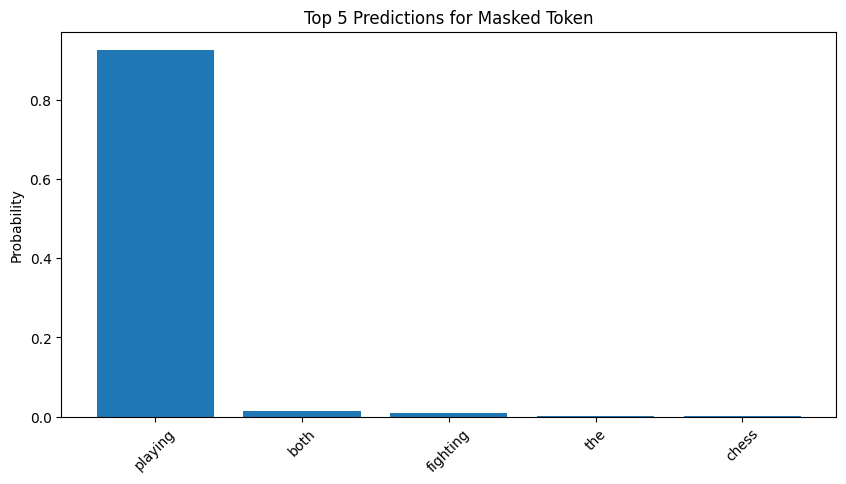

In [38]:
#Visualisation
plt.figure(figsize=(10, 5))
plt.bar(range(top_k), top_probs, align='center')
plt.xticks(range(top_k), top_tokens, rotation=45)
plt.ylabel('Probability')
plt.title(f'Top {top_k} Predictions for Masked Token')
plt.show()

## Question and Answering

In [40]:
context = "I am good at both chess and boxing"
question = "What am I good at?"

In [39]:
# We now use the question-answer tokenizer
qa_tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')
qa_model = BertForQuestionAnswering.from_pretrained("bert-large-uncased-whole-word-masking-finetuned-squad").to(device)
qa_model.eval()  # Also setting the model to evaluation mode

Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,)

In [41]:
#Tokenised inputs for the model
qa_inputs = qa_tokenizer.encode_plus(
    question, context,
    add_special_tokens=True,
    return_tensors="pt"
).to(device)

In [43]:
qa_tokens = qa_tokenizer.convert_ids_to_tokens(qa_inputs["input_ids"][0])
qa_tokens

['[CLS]',
 'what',
 'am',
 'i',
 'good',
 'at',
 '?',
 '[SEP]',
 'i',
 'am',
 'good',
 'at',
 'both',
 'chess',
 'and',
 'boxing',
 '[SEP]']

In [44]:
#Generating segment ids
input_ids = qa_inputs["input_ids"]
token_type_ids = qa_inputs["token_type_ids"]

In [45]:
token_type_ids[0].tolist()

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [46]:
#Getting predictions for answer locations in the context
with torch.no_grad():
    outputs = qa_model(**qa_inputs)

In [47]:
start_logits = outputs.start_logits
end_logits = outputs.end_logits

In [48]:
#Finding the most likely start and end positions
start_idx = torch.argmax(start_logits).item()
end_idx = torch.argmax(end_logits).item()

In [50]:
print(f"Predicted answer start position: {start_idx}")
print(f"Predicted answer end position: {end_idx}")

Predicted answer start position: 13
Predicted answer end position: 15


In [51]:
#Extracting the answer
answer_tokens = qa_inputs["input_ids"][0][start_idx:end_idx+1]
answer = qa_tokenizer.decode(answer_tokens)
answer

'chess and boxing'

In [52]:
#Evaluating the confidence scores using softmax
start_scores = torch.nn.functional.softmax(start_logits, dim=1)[0]
end_scores = torch.nn.functional.softmax(end_logits, dim=1)[0]
confidence = (start_scores[start_idx] * end_scores[end_idx]).item()
confidence

0.4384024143218994

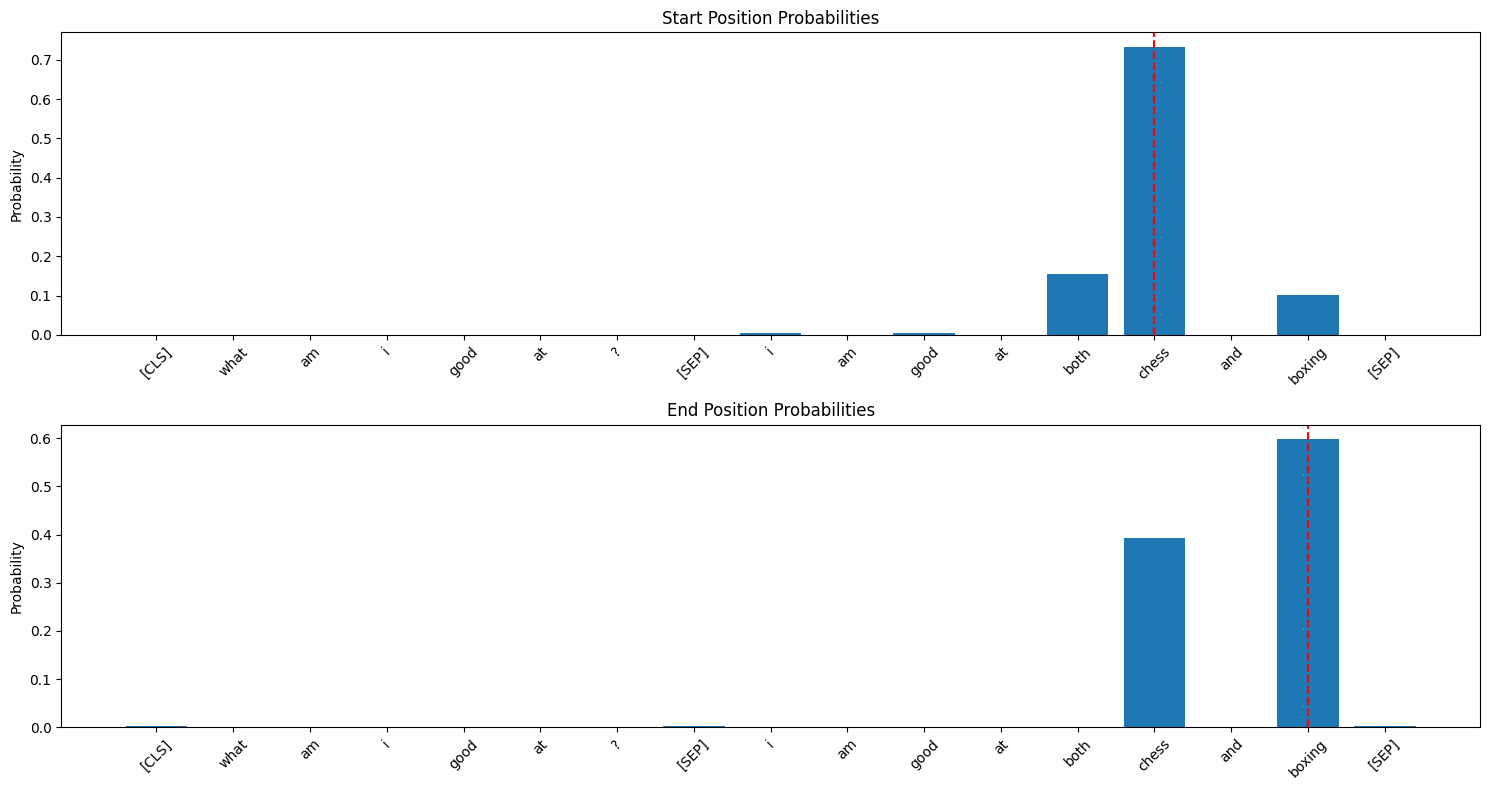

In [56]:
start_probs = torch.nn.functional.softmax(start_logits[0], dim=0).cpu().numpy()
end_probs = torch.nn.functional.softmax(end_logits[0], dim=0).cpu().numpy()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8))

# Plot start position probabilities
ax1.bar(range(len(qa_tokens)), start_probs)
ax1.set_xticks(range(len(qa_tokens)))
ax1.set_xticklabels(qa_tokens, rotation=45)
ax1.set_ylabel('Probability')
ax1.set_title('Start Position Probabilities')
ax1.axvline(x=start_idx, color='r', linestyle='--')

# Plot end position probabilities
ax2.bar(range(len(qa_tokens)), end_probs)
ax2.set_xticks(range(len(qa_tokens)))
ax2.set_xticklabels(qa_tokens, rotation=45)
ax2.set_ylabel('Probability')
ax2.set_title('End Position Probabilities')
ax2.axvline(x=end_idx, color='r', linestyle='--')

plt.tight_layout()
plt.show()

## Trying with a different question

In [57]:
new_question = "Am I good at the sport of chess-boxing?"

In [58]:
new_qa_inputs = qa_tokenizer.encode_plus(
    new_question, context,
    add_special_tokens=True,
    return_tensors="pt"
).to(device)

In [59]:
with torch.no_grad():
    new_outputs = qa_model(**new_qa_inputs)

In [60]:
new_start_idx = torch.argmax(new_outputs.start_logits).item()
new_end_idx = torch.argmax(new_outputs.end_logits).item()

In [61]:
new_start_scores = torch.nn.functional.softmax(new_outputs.start_logits, dim=1)[0]
new_end_scores = torch.nn.functional.softmax(new_outputs.end_logits, dim=1)[0]
new_confidence = (new_start_scores[new_start_idx] * new_end_scores[new_end_idx]).item()


In [62]:
new_answer_tokens = new_qa_inputs["input_ids"][0][new_start_idx:new_end_idx+1]
new_answer = qa_tokenizer.decode(new_answer_tokens)

In [63]:
new_answer

'i am good'

In [64]:
new_confidence

0.28704220056533813

## Summary

This notebook demonstrated two key BERT applications:
1. Masked Language Modeling - Successfully predicted masked words
2. Question Answering - Found answers to questions within context

Thus BERT showed its ability to understand language context and extract relevant information.